In [2]:
# coding: utf-8
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from os import listdir, makedirs
from os.path import join, isfile, isdir, exists
import pandas as pd
import gc
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import CoherenceModel, TfidfModel, LdaModel, LdaMulticore
from gensim.models.hdpmodel import HdpModel, HdpTopicFormatter
from gensim.models.callbacks import CoherenceMetric, DiffMetric, PerplexityMetric, ConvergenceMetric
from gensim.utils import revdict
from gensim import utils
from itertools import chain, islice
from constants import (
    FULL_PATH, ETL_PATH, NLP_PATH, SMPL_PATH, POS, NOUN, PROPN, TOKEN, HASH, SENT_IDX, PUNCT
)
import logging
import json
import numpy as np

#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
pd.options.display.max_rows = 2001


def report_on_oov_terms(cm, topic_models):
    """OOV = out-of-vocabulary"""
    topics_as_topn_terms = [
        models.CoherenceModel.top_topics_as_word_lists(model, dictionary)
        for model in topic_models
    ]

    oov_words = cm._accumulator.not_in_vocab(topics_as_topn_terms)
    print('number of oov words: %d' % len(oov_words))
    
    for num_topics, words in zip(trained_models.keys(), topics_as_topn_terms):
        oov_words = cm._accumulator.not_in_vocab(words)
        print('number of oov words for num_topics=%d: %d' % (num_topics, len(oov_words)))

#report_on_oov_terms(cm, trained_models.values())

datasets = {
    'E': 'Europarl',
    'FA': 'FAZ_combined',
    'FO': 'FOCUS_cleansed',
    'O': 'OnlineParticipation',
    'P': 'PoliticalSpeeches',
    'dewi': 'dewiki',
    'dewa': 'dewac',
}
bad_tokens = {
    'Europarl': [
        'E.', 'Kerr', 'The', 'la', 'ia', 'For', 'Ieke', 'the',
    ],
    'FAZ_combined': [
        'S.', 'j.reinecke@faz.de', 'B.',
    ],
    'FOCUS_cleansed': [],
    'OnlineParticipation': [
        'Re', '@#1', '@#2', '@#3', '@#4', '@#5', '@#6', '@#7', '@#8', '@#9', '@#1.1', 'Für', 'Muss',
        'etc', 'sorry', 'Ggf', 'u.a.', 'z.B.', 'B.', 'stimmt', ';-)', 'lieber', 'o.', 'Ja', 'Desweiteren',
    ],
    'PoliticalSpeeches': [],
    'dewiki': [],
    'dewac': [],
}
all_bad_tokens = set(chain(*bad_tokens.values()))
params_list = ['a42', 'b42', 'c42', 'd42', 'e42']
placeholder = '[[PLACEHOLDER]]'

dataset = datasets['O']
file = f'{dataset}_LDAmodel_a42_10'

# load model
ldamodel = LdaModel.load(join(ETL_PATH, 'LDAmodel', 'a42', file))
dict_from_model = ldamodel.id2word

split_type = 'fullset'
corpus_type = 'bow'
file_name = f'{dataset}_{split_type}_nouns_{corpus_type}'

# load dictionary
# !!! Attention: this is a different dictionary from model dict with a different word<->id mapping
dict_path = join(ETL_PATH, 'LDAmodel', file_name + '.dict')
dict_from_corpus = Dictionary.load(dict_path)
dict_from_corpus.add_documents([[placeholder]])
dict_from_corpus[0]

# load corpus (for u_mass scores)
corpus_path = join(ETL_PATH, 'LDAmodel', file_name + '.mm')
corpus = MmCorpus(corpus_path)
print(corpus)
corpus = list(corpus)
# this!
corpus.append([(dict_from_corpus.token2id[placeholder], 1.0)])

# load texts (for s_v scores)
doc_path = join(ETL_PATH, 'LDAmodel', file_name.rstrip(f'{corpus_type}') + 'texts.json')
with open(doc_path, 'r') as fp:
    texts = json.load(fp)
# this!
texts.append([placeholder])

# buil topic representation matrix
nbtopics = int(file.split('_')[-1])
topn = 20
topics = [
    [dataset] +
    [dict_from_model[term[0]] for term in ldamodel.get_topic_terms(i, topn=topn)]
    for i in range(nbtopics)
]
df_topics = pd.DataFrame(topics, columns=['dataset'] + ['term' + str(i) for i in range(topn)])
df_topics = df_topics.applymap(lambda x: placeholder if x in all_bad_tokens else x)
topic_terms = df_topics.iloc[:, 1:]
topic_terms

MmCorpus(25663 documents, 7137 features, 246941 non-zero entries)


,term0,term1,term2,term3,term4,term5,term6,term7,term8,term9,term10,term11,term12,term13,term14,term15,term16,term17,term18,term19
0,Stadt,Bürger,Jahr,Mensch,Projekt,Platz,Köln,Idee,[[PLACEHOLDER]],Möglichkeit,Wuppertal,Innenstadt,Beispiel,Arbeit,Student,Bürgerin,Stadt_Köln,Hund,Sache,Raum
1,Kind,Straßenbeleuchtung,Laterne,Beleuchtung,Straßenlaterne,Spielplatz,Vorschlag,Straße,Woche,Tag,Bereich,Haus,Rampe,Müll,Lampe,Godesberg,Höhe,Zeit,Engelshof,Gehwegplatte
2,Kind,Schule,Stadt,Jahr,Gebäude,Geld,Bad_Godesberg,Platz,Jugendliche,Mensch,Angebot,Vorschlag,Köln,Bürger,Grünfläche,Bereich,Park,Leben,Vielfalt,Teil
3,Vorschlag,Moderation,Verwaltung,Gruß,Stadtverwaltung,Kommentar,Dank,Hinweis,Dialog,[[PLACEHOLDER]],Hochschule,Unterstützung,Bürgerhaushalt,Frage,Aussage,Meinung,Weg,Antwort,Haushalt,Ende
4,Beitrag,Vorschlag,Dank,Kategorie,Verständnis,Thema,Auswertung,Moderation,Themenbereich,Radverkehrsführung,Hallo,Gast,Herr,Wähner,Moderation_Nowzamani,Mädchen,Hindernis,Dame,Sonstiges,Moderation_Escher
5,Bonn,Euro,Mitarbeiter,Oper,Stadt,Vorschlag,Jahr,Kosten,Toilette,Geld,Köln,Festival,Zeit,Baum,Verwaltung,Schüler,Festspielhaus,Förderung,Unternehmen,Stadt_Bonn
6,Radweg,Radfahrer,Fußgänger,Straße,Fahrradstraße,Rad,Seite,Richtung,Auto,Problem,Poller,Stadt,Ampel,Gehweg,Höhe,Platz,Kreuzung,Bereich,Verkehr,Brücke
7,Auto,Parkplatz,Stelle,Monat,Park,Leute,Weg,Fahrrad,Rad,Jahr,Mensch,Frau,EUR,Fahrradständer,Stadt,Reihe,Köln,Sicherheit,Zeit,Anhänger
8,Stadt,Köln,Kosten,Einnahme,KVB,Stadt_Köln,Bus,Fahrzeug,Verkehrssicherheit,Vorschlag,Gehweg,Erhöhung,Geld,Problem,Innenstadt,Personal,Bahn,Haushalt,Stadtbahn,Haltestelle
9,Radfahrer,Straße,Richtung,Autofahrer,Auto,Radweg,Weg,Ampel,Fußgänger,Fahrradweg,Fahrradfahrer,Fahrrad,Fahrbahn,Kreuzung,Stelle,Kreisverkehr,Bürgersteig,Schild,Einbahnstraße,Fahrtrichtung


In [52]:
# reference scores per topic for top 10 topic terms

ref_topics = topic_terms.iloc[:, :10]

top10_topics = ref_topics.values.tolist()

cm_umass_ref = CoherenceModel(topics=top10_topics, corpus=corpus, dictionary=dict_from_corpus, coherence='u_mass', topn=10)
umass_scores_ref = cm_umass_ref.get_coherence_per_topic(
    #segmented_topics=topics, with_std=False, with_support=False
)
cm_cv_ref = CoherenceModel(topics=top10_topics, texts=texts, dictionary=dict_from_corpus, coherence='c_v', topn=10)
cv_scores_ref = cm_cv_ref.get_coherence_per_topic(
    #segmented_topics=topics, with_std=False, with_support=False
)

print(umass_scores_ref)
print(cv_scores_ref)

-----

debugging interlude >>>

http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf

$m_{lc}(S_i) = log \frac{P(W', W^{*}) + \epsilon}{P(W^{*})}$

In [ ]:
dict_from_corpus[491], dict_from_corpus[7137], dict_from_model[491], dict_from_model[7137]

<<< debugging

-----

-----

We will now determine which of the top 20 topic termins are most distracting for the topic coherence and omit them as topic references.

In [4]:
shifted_frames = []
for i in range(topn):
    df = pd.DataFrame(np.roll(topic_terms.values, shift=-i, axis=1))
    shifted_frames.append(df)
shifted_terms = pd.concat(shifted_frames)
shifted_terms

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Stadt,Bürger,Jahr,Mensch,Projekt,Platz,Köln,Idee,[[PLACEHOLDER]],Möglichkeit,Wuppertal,Innenstadt,Beispiel,Arbeit,Student,Bürgerin,Stadt_Köln,Hund,Sache,Raum
1,Kind,Straßenbeleuchtung,Laterne,Beleuchtung,Straßenlaterne,Spielplatz,Vorschlag,Straße,Woche,Tag,Bereich,Haus,Rampe,Müll,Lampe,Godesberg,Höhe,Zeit,Engelshof,Gehwegplatte
2,Kind,Schule,Stadt,Jahr,Gebäude,Geld,Bad_Godesberg,Platz,Jugendliche,Mensch,Angebot,Vorschlag,Köln,Bürger,Grünfläche,Bereich,Park,Leben,Vielfalt,Teil
3,Vorschlag,Moderation,Verwaltung,Gruß,Stadtverwaltung,Kommentar,Dank,Hinweis,Dialog,[[PLACEHOLDER]],Hochschule,Unterstützung,Bürgerhaushalt,Frage,Aussage,Meinung,Weg,Antwort,Haushalt,Ende
4,Beitrag,Vorschlag,Dank,Kategorie,Verständnis,Thema,Auswertung,Moderation,Themenbereich,Radverkehrsführung,Hallo,Gast,Herr,Wähner,Moderation_Nowzamani,Mädchen,Hindernis,Dame,Sonstiges,Moderation_Escher
5,Bonn,Euro,Mitarbeiter,Oper,Stadt,Vorschlag,Jahr,Kosten,Toilette,Geld,Köln,Festival,Zeit,Baum,Verwaltung,Schüler,Festspielhaus,Förderung,Unternehmen,Stadt_Bonn
6,Radweg,Radfahrer,Fußgänger,Straße,Fahrradstraße,Rad,Seite,Richtung,Auto,Problem,Poller,Stadt,Ampel,Gehweg,Höhe,Platz,Kreuzung,Bereich,Verkehr,Brücke
7,Auto,Parkplatz,Stelle,Monat,Park,Leute,Weg,Fahrrad,Rad,Jahr,Mensch,Frau,EUR,Fahrradständer,Stadt,Reihe,Köln,Sicherheit,Zeit,Anhänger
8,Stadt,Köln,Kosten,Einnahme,KVB,Stadt_Köln,Bus,Fahrzeug,Verkehrssicherheit,Vorschlag,Gehweg,Erhöhung,Geld,Problem,Innenstadt,Personal,Bahn,Haushalt,Stadtbahn,Haltestelle
9,Radfahrer,Straße,Richtung,Autofahrer,Auto,Radweg,Weg,Ampel,Fußgänger,Fahrradweg,Fahrradfahrer,Fahrrad,Fahrbahn,Kreuzung,Stelle,Kreisverkehr,Bürgersteig,Schild,Einbahnstraße,Fahrtrichtung


In [5]:
# omit the first topic term, then the second and append the first etc...
top19_topics = shifted_terms.iloc[:, 1:].values.tolist()
print(np.asarray(top19_topics).shape)

(200, 19)


In [6]:
# leads to ZeroDivisionError: float division by zero
#File "/home/andreas/bin/anaconda3/lib/python3.6/site-packages/gensim/topic_coherence/direct_confirmation_measure.py", line 73, in log_conditional_probability
#    m_lc_i = np.log(((co_occur_count / num_docs) + EPSILON) / (w_star_count / num_docs))
#ZeroDivisionError: float division by zero
# fixed in gensim: add ZeroDivisionError to except clause

# calculate the scores for all shifted topics
# !!! TODO: we might reuse the reference models for the probability extimation here!!!
cm_umass = CoherenceModel(topics=top19_topics, corpus=corpus, dictionary=dict_from_corpus, coherence='u_mass', topn=topn-1)
umass_scores = cm_umass.get_coherence_per_topic(
    #segmented_topics=topics, with_std=False, with_support=False
)
cm_cv = CoherenceModel(topics=top19_topics, texts=texts, dictionary=dict_from_corpus, coherence='c_v', topn=topn-1)
cv_scores = cm_cv.get_coherence_per_topic(
    #segmented_topics=topics, with_std=False, with_support=False
)
# more gensim bugs:
#/home/andreas/bin/anaconda3/lib/python3.6/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:199: RuntimeWarning: divide by zero encountered in double_scalars
#  m_lr_i = np.log(numerator / denominator)
#/home/andreas/bin/anaconda3/lib/python3.6/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:317: RuntimeWarning: invalid value encountered in double_scalars
#  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))

umass_scores

[-5.994581139891962,
 -7.8034997252086375,
 -3.180873795439493,
 -6.28945920748917,
 -5.016535543035529,
 -4.562369813141005,
 -2.8913016721181677,
 -4.362748097162751,
 -4.100317154948871,
 -2.799583632697539,
 -5.784021294615594,
 -7.393900242943282,
 -3.091092978097869,
 -5.992990651901187,
 -4.821565987811206,
 -4.471164869943743,
 -2.7967955268533498,
 -4.247962769198553,
 -3.889443570069974,
 -2.6443865963985043,
 -5.63575582582266,
 -7.577189757544043,
 -3.0784338918048237,
 -5.944692881180588,
 -4.689794215627543,
 -4.358764503849209,
 -2.6814272361393723,
 -4.199845880952224,
 -3.7484220054691924,
 -2.5614437156463983,
 -5.4782612907356,
 -7.617491370077128,
 -2.908506306736158,
 -5.781270546036962,
 -4.504071635420615,
 -4.5183128861903565,
 -2.6315831473355518,
 -4.158972709934268,
 -3.7268021990152636,
 -2.4812917360953954,
 -5.291333372825706,
 -7.290312333503953,
 -2.8055025569519527,
 -5.785256401460374,
 -4.573845348392486,
 -4.527473337512854,
 -2.532614345913882,
 -4.

In [7]:
# TODO: encapsulate as function
umass2d = np.reshape(umass_scores, (topn, -1)).T
cv2d = np.reshape(cv_scores, (topn, -1)).T

umass2d

array([[-5.99458114, -5.78402129, -5.63575583, -5.47826129, -5.29133337,
        -5.3145294 , -5.22006035, -5.04263051, -3.50605944, -5.68315784,
        -5.47158518, -5.71351091, -5.6779673 , -5.63673331, -5.23584928,
        -5.63007376, -5.79143161, -5.49182779, -5.81624493, -6.01270192],
       [-7.80349973, -7.39390024, -7.57718976, -7.61749137, -7.29031233,
        -7.56846772, -7.55739277, -7.39657252, -7.16164371, -7.22430259,
        -7.13259246, -7.06768181, -6.48149405, -6.70612065, -6.90225664,
        -6.90282106, -7.50742181, -7.34685511, -5.87621089, -6.65195096],
       [-3.1808738 , -3.09109298, -3.07843389, -2.90850631, -2.80550256,
        -2.86471172, -2.80806782, -2.84667   , -2.87083909, -2.9062509 ,
        -2.89442197, -2.83122185, -2.722828  , -2.65908493, -2.59896009,
        -2.74721176, -2.72217314, -2.80643081, -2.94800118, -3.16624527],
       [-6.28945921, -5.99299065, -5.94469288, -5.78127055, -5.7852564 ,
        -5.66732489, -5.59860049, -5.47880426, -

In [8]:
# as a reference
print(np.max(umass2d, axis=1))
umass_worst = np.argmax(umass2d, axis=1)
print(umass_worst)
for i in range(len(topic_terms)):
    print(topic_terms.iat[i, umass_worst[i]])

[-3.50605944 -5.87621089 -2.59896009 -4.07416218 -3.04710296 -3.2402707
 -2.51639622 -3.6023825  -3.50931    -2.11048124]
[ 8 18 14  9 15 11  9 13  8  9]
[[PLACEHOLDER]]
Engelshof
Grünfläche
[[PLACEHOLDER]]
Mädchen
Festival
Problem
Fahrradständer
Verkehrssicherheit
Fahrradweg


In [9]:
# the highest values indicate the terms whose absence improves the topic coherence most
umass_sorted = np.argsort(umass2d, axis=1)
cv_sorted = np.argsort(cv2d, axis=1)

umass_sorted

array([[19,  0, 18, 16,  1, 11,  9, 12, 13,  2, 15, 17,  3, 10,  5,  4,
        14,  6,  7,  8],
       [ 0,  3,  2,  5,  6, 16,  7,  1, 17,  4,  9,  8, 10, 11, 15, 14,
        13, 19, 12, 18],
       [ 0, 19,  1,  2, 18,  3,  9, 10,  8,  5,  7, 11,  6, 17,  4, 15,
        12, 16, 13, 14],
       [14, 12, 13, 18, 15, 16, 19, 11,  0, 17,  1,  2,  4,  3,  5,  6,
         7,  8, 10,  9],
       [ 0,  1,  2, 18,  4,  3, 16,  5, 19, 11,  6, 10,  8,  9,  7, 12,
        13, 14, 17, 15],
       [ 0, 19,  4,  3,  1,  2, 18,  5, 12, 14,  6, 17,  9, 16, 15, 10,
         7, 13,  8, 11],
       [ 0,  1, 19, 18, 16,  7, 17, 15,  6,  2,  8,  5, 11, 14,  3, 13,
        12,  4, 10,  9],
       [ 0, 14,  1, 18,  6,  4,  2,  3,  7, 16,  8,  9, 17, 15, 19,  5,
        10, 12, 11, 13],
       [ 0, 19,  9,  1, 12,  5,  6, 16,  2, 13,  7, 17,  3, 11,  4, 18,
        14, 10, 15,  8],
       [ 0, 19,  1,  2, 18,  3, 17,  4, 16,  5, 13, 12, 14, 11, 10, 15,
         6,  8,  7,  9]])

In [57]:
# thus we will keep the first 10 indices
umass_top = umass_sorted[:, :10]
cv_top = cv_sorted[:, :10]
#print(umass_top)
# and sort them back for convenience
umass_top = np.sort(umass_top, axis=1)
cv_top = np.sort(cv_top, axis=1)
print(umass_top)
print(cv_top)

[[ 0  1  2  9 11 12 13 16 18 19]
 [ 0  1  2  3  4  5  6  7 16 17]
 [ 0  1  2  3  5  8  9 10 18 19]
 [ 0 11 12 13 14 15 16 17 18 19]
 [ 0  1  2  3  4  5 11 16 18 19]
 [ 0  1  2  3  4  5 12 14 18 19]
 [ 0  1  2  6  7 15 16 17 18 19]
 [ 0  1  2  3  4  6  7 14 16 18]
 [ 0  1  2  5  6  9 12 13 16 19]
 [ 0  1  2  3  4  5 16 17 18 19]]
[[ 0  1  2  3  4  6  8  9 11 12]
 [ 1  3  5  7  8  9 14 17 18 19]
 [ 0  1  2  3  5  8  9 10 13 17]
 [ 1  2  3  4  5  7  8 12 13 17]
 [ 0  2  3  4  5  6  8  9 11 18]
 [ 0  1  3  4  6  7  9 12 14 19]
 [ 0  1  2  3  6  7  8 12 16 18]
 [ 0  1  2  3  4  7  9 14 16 18]
 [ 0  1  2  3  4  5 11 12 14 16]
 [ 0  1  2  3  4  5  8  9 10 12]]


In [68]:
# out of place score compared to the reference topics
refi = np.mgrid[0:10,0:10][0].T
print(np.abs(umass_top - refi).sum())
print(np.abs(cv_top - refi).sum())

419
257


In [46]:
umass_topics = []
cv_topics = []
for i in range(10):
    umass_topic = topic_terms.values[i, umass_top[i]]
    umass_topics.append(umass_topic)
    cv_topic = topic_terms.values[i, cv_top[i]]
    cv_topics.append(cv_topic)

umass_topics = pd.DataFrame.from_records(umass_topics, columns=ref_topics.columns[:10])
cv_topics = pd.DataFrame.from_records(cv_topics, columns=ref_topics.columns[:10])

In [47]:
ref_topics

,term0,term1,term2,term3,term4,term5,term6,term7,term8,term9,source
0,Stadt,Bürger,Jahr,Mensch,Projekt,Platz,Köln,Idee,[[PLACEHOLDER]],Möglichkeit,ref
1,Kind,Straßenbeleuchtung,Laterne,Beleuchtung,Straßenlaterne,Spielplatz,Vorschlag,Straße,Woche,Tag,ref
2,Kind,Schule,Stadt,Jahr,Gebäude,Geld,Bad_Godesberg,Platz,Jugendliche,Mensch,ref
3,Vorschlag,Moderation,Verwaltung,Gruß,Stadtverwaltung,Kommentar,Dank,Hinweis,Dialog,[[PLACEHOLDER]],ref
4,Beitrag,Vorschlag,Dank,Kategorie,Verständnis,Thema,Auswertung,Moderation,Themenbereich,Radverkehrsführung,ref
5,Bonn,Euro,Mitarbeiter,Oper,Stadt,Vorschlag,Jahr,Kosten,Toilette,Geld,ref
6,Radweg,Radfahrer,Fußgänger,Straße,Fahrradstraße,Rad,Seite,Richtung,Auto,Problem,ref
7,Auto,Parkplatz,Stelle,Monat,Park,Leute,Weg,Fahrrad,Rad,Jahr,ref
8,Stadt,Köln,Kosten,Einnahme,KVB,Stadt_Köln,Bus,Fahrzeug,Verkehrssicherheit,Vorschlag,ref
9,Radfahrer,Straße,Richtung,Autofahrer,Auto,Radweg,Weg,Ampel,Fußgänger,Fahrradweg,ref


In [48]:
umass_topics

,term0,term1,term2,term3,term4,term5,term6,term7,term8,term9
0,Stadt,Bürger,Jahr,Möglichkeit,Innenstadt,Beispiel,Arbeit,Stadt_Köln,Sache,Raum
1,Kind,Straßenbeleuchtung,Laterne,Beleuchtung,Straßenlaterne,Spielplatz,Vorschlag,Straße,Höhe,Zeit
2,Kind,Schule,Stadt,Jahr,Geld,Jugendliche,Mensch,Angebot,Vielfalt,Teil
3,Vorschlag,Unterstützung,Bürgerhaushalt,Frage,Aussage,Meinung,Weg,Antwort,Haushalt,Ende
4,Beitrag,Vorschlag,Dank,Kategorie,Verständnis,Thema,Gast,Hindernis,Sonstiges,Moderation_Escher
5,Bonn,Euro,Mitarbeiter,Oper,Stadt,Vorschlag,Zeit,Verwaltung,Unternehmen,Stadt_Bonn
6,Radweg,Radfahrer,Fußgänger,Seite,Richtung,Platz,Kreuzung,Bereich,Verkehr,Brücke
7,Auto,Parkplatz,Stelle,Monat,Park,Weg,Fahrrad,Stadt,Köln,Zeit
8,Stadt,Köln,Kosten,Stadt_Köln,Bus,Vorschlag,Geld,Problem,Bahn,Haltestelle
9,Radfahrer,Straße,Richtung,Autofahrer,Auto,Radweg,Bürgersteig,Schild,Einbahnstraße,Fahrtrichtung


In [49]:
cv_topics

,term0,term1,term2,term3,term4,term5,term6,term7,term8,term9
0,Stadt,Bürger,Jahr,Mensch,Projekt,Köln,[[PLACEHOLDER]],Möglichkeit,Innenstadt,Beispiel
1,Straßenbeleuchtung,Beleuchtung,Spielplatz,Straße,Woche,Tag,Lampe,Zeit,Engelshof,Gehwegplatte
2,Kind,Schule,Stadt,Jahr,Geld,Jugendliche,Mensch,Angebot,Bürger,Leben
3,Moderation,Verwaltung,Gruß,Stadtverwaltung,Kommentar,Hinweis,Dialog,Bürgerhaushalt,Frage,Antwort
4,Beitrag,Dank,Kategorie,Verständnis,Thema,Auswertung,Themenbereich,Radverkehrsführung,Gast,Sonstiges
5,Bonn,Euro,Oper,Stadt,Jahr,Kosten,Geld,Zeit,Verwaltung,Stadt_Bonn
6,Radweg,Radfahrer,Fußgänger,Straße,Seite,Richtung,Auto,Ampel,Kreuzung,Verkehr
7,Auto,Parkplatz,Stelle,Monat,Park,Fahrrad,Jahr,Stadt,Köln,Zeit
8,Stadt,Köln,Kosten,Einnahme,KVB,Stadt_Köln,Erhöhung,Geld,Innenstadt,Bahn
9,Radfahrer,Straße,Richtung,Autofahrer,Auto,Radweg,Fußgänger,Fahrradweg,Fahrradfahrer,Fahrbahn


In [15]:
# scores per topic for top 10 topic terms by u_mass selection

top10_topics = umass_topics.values.tolist()
cm_umass_u = CoherenceModel(topics=top10_topics, corpus=corpus, dictionary=dict_from_corpus, coherence='u_mass', topn=10)
umass_scores_u = cm_umass_u.get_coherence_per_topic(
    #segmented_topics=topics, with_std=False, with_support=False
)
cm_cv_u = CoherenceModel(topics=top10_topics, texts=texts, dictionary=dict_from_corpus, coherence='c_v', topn=10)
cv_scores_u = cm_cv_u.get_coherence_per_topic(
    #segmented_topics=topics, with_std=False, with_support=False
)

print(umass_scores_u)
print(cv_scores_u)

[-3.243966267620917, -3.3755008571522853, -2.967323339181271, -3.6914064820214816, -1.6835056682272411, -2.8197260615295, -2.60266208574209, -2.689630558709717, -3.055770267045432, -2.5868850130298378]
[0.5917199650286183, 0.3044288145640909, 0.6798373976381378, 0.4334193382902033, 0.9547315310072708, 0.6518195129812177, 0.6311030047482243, 0.5273019860225812, 0.5146057016095552, 0.7745980880861206]


In [16]:
# scores per topic for top 10 topic terms by c_v selection

top10_topics = cv_topics.values.tolist()
cm_umass_c = CoherenceModel(topics=top10_topics, corpus=corpus, dictionary=dict_from_corpus, coherence='u_mass', topn=10)
umass_scores_c = cm_umass_c.get_coherence_per_topic(
    #segmented_topics=topics, with_std=False, with_support=False
)
cm_cv_c = CoherenceModel(topics=top10_topics, texts=texts, dictionary=dict_from_corpus, coherence='c_v', topn=10)
cv_scores_c = cm_cv_c.get_coherence_per_topic(
    #segmented_topics=topics, with_std=False, with_support=False
)

print(umass_scores_c)
print(cv_scores_c)

[-6.545532657204666, -9.724838211033651, -2.5981222839570863, -2.728188183542655, -0.9074308774483335, -2.425894290678385, -2.0619410207169664, -2.6014591772668747, -2.9684588476739684, -2.0889704883446334]
[0.5605582713196847, 0.4621182161376517, 0.709533852803024, 0.7001664687717593, 0.9872050618941632, 0.75047936782437, 0.7530941223489295, 0.5485213972846942, 0.7157152362349206, 0.8013123606362325]


In [54]:
df_u = pd.DataFrame([umass_scores_ref, umass_scores_u, umass_scores_c], index=['reference', 'u_mass', 'c_v']).T
df_u.describe()

,reference,u_mass,c_v
count,10.000000,10.000000,10.000000
mean,-3.374057,-2.871638,-3.465084
std,1.918271,0.548584,2.634068
min,-6.767347,-3.691406,-9.724838
25%,-3.554271,-3.196917,-2.908391
50%,-2.790760,-2.893525,-2.599791
75%,-2.325584,-2.624404,-2.173201
max,-0.884698,-1.683506,-0.907431


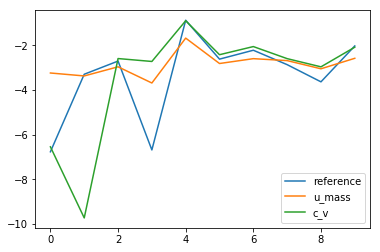

In [19]:
df_u.plot()

In [55]:
df_c = pd.DataFrame([cv_scores_ref, cv_scores_u, cv_scores_c], index=['reference', 'u_mass', 'c_v']).T
df_c.describe()

,reference,u_mass,c_v
count,10.000000,10.000000,10.000000
mean,0.619652,0.606357,0.698870
std,0.161203,0.180647,0.148107
min,0.399491,0.304429,0.462118
25%,0.522467,0.517780,0.595460
50%,0.588005,0.611411,0.712625
75%,0.667655,0.672833,0.752440
max,0.973816,0.954732,0.987205


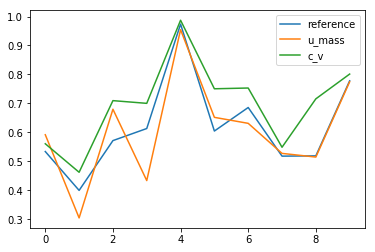

In [20]:
df_c.plot()

In [53]:
ref_topics['source'] = 'ref'
umass_topics['source'] = 'umass'
cv_topics['source'] = 'cv'

pd.concat([ref_topics, umass_topics, cv_topics], axis=0).sort_index(kind='mergesort')

/home/andreas/bin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,term0,term1,term2,term3,term4,term5,term6,term7,term8,term9,source
0,Stadt,Bürger,Jahr,Mensch,Projekt,Platz,Köln,Idee,[[PLACEHOLDER]],Möglichkeit,ref
0,Stadt,Bürger,Jahr,Möglichkeit,Innenstadt,Beispiel,Arbeit,Stadt_Köln,Sache,Raum,umass
0,Stadt,Bürger,Jahr,Mensch,Projekt,Köln,[[PLACEHOLDER]],Möglichkeit,Innenstadt,Beispiel,cv
1,Kind,Straßenbeleuchtung,Laterne,Beleuchtung,Straßenlaterne,Spielplatz,Vorschlag,Straße,Woche,Tag,ref
1,Kind,Straßenbeleuchtung,Laterne,Beleuchtung,Straßenlaterne,Spielplatz,Vorschlag,Straße,Höhe,Zeit,umass
1,Straßenbeleuchtung,Beleuchtung,Spielplatz,Straße,Woche,Tag,Lampe,Zeit,Engelshof,Gehwegplatte,cv
2,Kind,Schule,Stadt,Jahr,Gebäude,Geld,Bad_Godesberg,Platz,Jugendliche,Mensch,ref
2,Kind,Schule,Stadt,Jahr,Geld,Jugendliche,Mensch,Angebot,Vielfalt,Teil,umass
2,Kind,Schule,Stadt,Jahr,Geld,Jugendliche,Mensch,Angebot,Bürger,Leben,cv
3,Vorschlag,Moderation,Verwaltung,Gruß,Stadtverwaltung,Kommentar,Dank,Hinweis,Dialog,[[PLACEHOLDER]],ref


<<< valid code ends

-----

ignore from here >>>

In [ ]:
top_topics = ldamodel.top_topics(corpus, topn=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / len(top_topics)
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

In [ ]:
coherences = []
for topic in topics:
    cm = CoherenceModel(topics=[topic], corpus=corpus, dictionary=dict_from_corpus, coherence='u_mass')
    coherences.append(cm.get_coherence())
coherences

In [ ]:
sum(coherences) / len(coherences)

In [ ]:
cmlda = CoherenceModel(model=ldamodel, corpus=corpus, coherence='u_mass')
cmlda.get_coherence()
cmhdp = CoherenceModel(model=hdpmodel, corpus=corpus, coherence='u_mass')
cmhdp.get_coherence()

In [ ]:
cm = CoherenceModel.for_topics(topics_as_topn_terms=topics, corpus=corpus, dictionary=dictionary, coherence='u_mass')

In [ ]:
cm.get_coherence_per_topic(segmented_topics=topics, with_std=True, with_support=True)


### Evaluation

In [ ]:
MmCorpus.serialize('../data/{}.mm'.format(dataset), corpus)
corpus_fake = MmCorpus('../data/{}.mm'.format(dataset))
prepared_data = ldavis.gensim.prepare(ldamodel, corpus_fake, dictionary)
prepared_data

In [ ]:
# To get the topic words from the model
topics = []
for topic_id, topic in hm.show_topics(num_topics=10, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)
topics[:2]

# Initialize CoherenceModel using `topics` parameter
coherences = []
for topic in topics:
    cm = CoherenceModel(topics=[topic], corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherences.append(cm.get_coherence())
coherences

sum(coherences) / len(coherences)

### Start c_v coherence measure
This is expected to take much more time since `c_v` uses a sliding window to perform probability estimation and uses the cosine similarity indirect confirmation measure.

In [ ]:
%%time

cm = CoherenceModel(topics=usable_topics, texts=texts, dictionary=dictionary, coherence='c_v')
c_v = cm.get_coherence_per_topic()
print("Calculated c_v coherence for %d topics" % len(c_v))

### Start c_uci and c_npmi coherence measures
c_v and c_uci and c_npmi all use the boolean sliding window approach of estimating probabilities. Since the `CoherenceModel` caches the accumulated statistics, calculation of c_uci and c_npmi are practically free after calculating c_v coherence. These two methods are simpler and were shown to correlate less with human judgements than c_v but more so than u_mass.

In [ ]:
%%time

cm.coherence = 'c_uci'
c_uci = cm.get_coherence_per_topic()
print("Calculated c_uci coherence for %d topics" % len(c_uci))

In [ ]:
%%time

cm.coherence = 'c_npmi'
c_npmi = cm.get_coherence_per_topic()
print("Calculated c_npmi coherence for %d topics" % len(c_npmi))

In [ ]:
final_scores = [
    score for i, score in enumerate(human_scores)
    if i not in invalid_topic_indices
]
len(final_scores)

The [values in the paper](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) were:

__`u_mass` correlation__ : 0.093

__`c_v` correlation__    : 0.548

__`c_uci` correlation__  : 0.473

__`c_npmi` correlation__ : 0.438

Our values are also very similar to these values which is good. This validates the correctness of our pipeline, as we can reasonably attribute the differences to differences in preprocessing.

In [ ]:
for our_scores in (u_mass, c_v, c_uci, c_npmi):
    print(pearsonr(our_scores, final_scores)[0])
sum(u_mass)/99, sum(c_v)/99, sum(c_uci)/99, sum(c_npmi)/99